<a href="https://colab.research.google.com/github/bforoura/GENAI26/blob/main/Module3/LangGraph_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LangGraph Fundamentals**


---
* LangGraph's core idea is using a graph for the application's workflow. This graph has two main parts: **nodes** and **edges**.

1. **Nodes**:
    * Nodes are the fundamental building blocks representing discrete units of work or computation within the workflow.
    * Each node is a Python function that processes the current state and returns an updated state.
    * Nodes can perform tasks such as calling an LLM and interacting with tools or APIs for manipulating data.


2. **Edges**:
  * Edges connect nodes and define the flow of execution.
  * **Simple edges**: Direct, unconditional transitions from one node to another.
  * **Conditional edges**: Branching logic that directs flow based on node outputs, similar to if-else statements. This allows dynamic decision-making within the workflow.


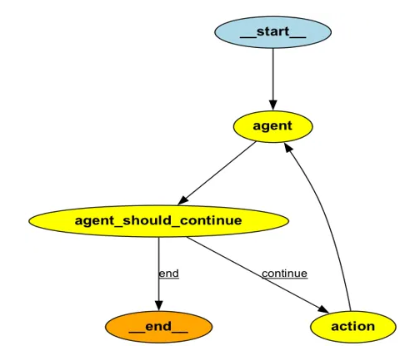

---
### **State Management**

* Keeping track of what's happening is vital when you have many agents.
* All agents need to know the current status of the task.
* LangGraph handles this by managing the state automatically.
* The library keeps track of and updates a main state object. It does this as the agents do their jobs.
* The state object holds important information. It's available at different points in the workflow. This could include the chat history.

* In a **chatbot**, the **state** can save the **conversation**.
  * This helps the bot respond using what was said before.
  * It can also store context data, like user likes, past actions, etc. or external data.

* Agents can use this for making choices.
* **Internal variables** can also be kept here.
* Agents might use the state to track flags, counts, or other values. These help guide their actions and decisions.
---

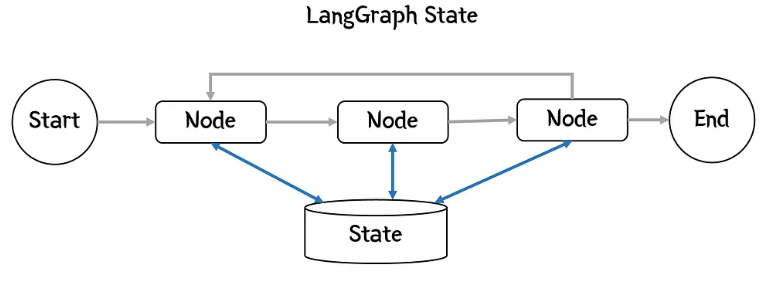

In [ ]:
!pip install -U langchain-google-genai langgraph

In [ ]:
import os
from google.colab import userdata

# load up the key
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")


# **Example 1**

* Let's create an **agent** that analyzes a provided job description and if it fits my profile, it generated an application.

* We'll fake the application logic itself, and work only on the flow for now:

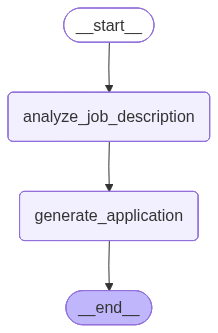

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# --- 1. DEFINE THE DATA STRUCTURE ---
# This class defines the "schema" or memory of our graph.
# It determines what data is passed from one step to the next.

class JobApplicationState(TypedDict):
    job_description: str  # Input: the text of the job post
    is_suitable: bool     # Logic: result of the analysis
    application: str      # Output: the generated letter



# --- 2. DEFINE THE NODES (ACTIONS) ---
# Each function takes the current 'state' and returns an update to that state.

def analyze_job_description(state):
    """Checks if the job description is long enough to be valid."""
    print("...Analyzing a provided job description ...")
    # We return a dictionary update for the 'is_suitable' key
    return {"is_suitable": len(state["job_description"]) > 100}

def generate_application(state):
    """Creates a placeholder application text."""
    print("...generating application...")
    # We return a dictionary update for the 'application' key
    return {"application": "some_fake_application"}



# --- 3. CONSTRUCT THE GRAPH ---

# Initialize the graph builder using our state definition
builder = StateGraph(JobApplicationState)

# Register our functions as "Nodes" (steps in the process)
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)

# Define the "Edges" (the arrows connecting the nodes)
builder.add_edge(START, "analyze_job_description")         # Start -> Analysis
builder.add_edge("analyze_job_description", "generate_application") # Analysis -> Generation
builder.add_edge("generate_application", END)             # Generation -> End




# --- 4. COMPILE AND VISUALIZE ---

# Compile turns the blueprint into an executable object
graph = builder.compile()

# Visualize the flow using a Mermaid diagram (rendered as a PNG)
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))



# **Runnable**

* In **LangChain** and **LangGraph**, the term **Runnable** is a specific **interface** or a **set of rules**.

* **isinstance(graph, Runnable)** checks to see if the graph follows the LangChain Expression Language (LCEL) standard. If it returns **True**, it means the graph is now compatible with a whole suite of tools.

* By being **Runnable**, a graph automatically gains several built-in methods without having to write any extra code:

  1) .**invoke**(): The standard way to run the graph **synchronously**.

  2) .**ainvoke**(): Running the graph **asynchronously**; useful for web servers. In Python, **async functions** return a coroutine object (a promise to do work) rather than the actual result. Because we aren't telling the computer to "wait" for that promise to finish, the code essentially sits in limbo, or we're just looking at a pending object without executing it.

  3) .**stream**(): Allows you to see the output of each node as it happens, rather than waiting for the very end.

  4) .**batch**(): Running multiple job descriptions through the graph at the same time efficiently.




* A graph instance itself is a Runnable (to be precise, it inherits from Runnable) and we can execute  it.

* In below, we should provide a dictionary with the initial state, and we'll get the final state as an output:



In [ ]:
from langchain_core.runnables import Runnable


# See if the graph follows the LangChain Expression Language (LCEL) standard.
isinstance(graph, Runnable)


True

In [ ]:
#  run the graph synchronously

res = graph.invoke({"job_description":"fake_jd"})
print(res)



...Analyzing a provided job description ...
...generating application...
{'job_description': 'fake_jd', 'is_suitable': False, 'application': 'some_fake_application'}


# **Example 2**

* Now, let's make our logic a little bit more complex and make an **edge conditional**.

* Conditional edges are visualized with dotted lines, and now we can see that, depending on the output of the **analyze_job_description** step, our graph can perform different actions.

* In other words, our flow would depend on the previous outcomes (of an LLM):


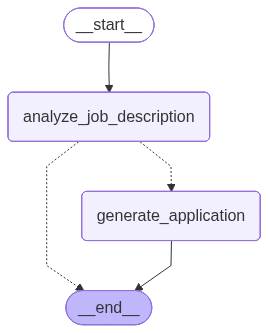

In [ ]:
from typing import Literal

# --- 1. INITIALIZE THE GRAPH ---
# Create the builder with the State schema we defined earlier
builder = StateGraph(JobApplicationState)



# --- 2. ADD THE NODES ---
# Register the functions that perform the work
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)



# --- 3. DEFINE CONDITIONAL LOGIC ---
# This function acts as a 'router' or 'decision maker'
def is_suitable_condition(state: JobApplicationState) -> Literal["generate_application", END]:
    """
    Looks at the 'is_suitable' flag in the current state.
    If True: Go to the generation node.
    If False: Go straight to the END of the process.
    """
    if state.get("is_suitable"):
        return "generate_application"
    return END



# --- 4. CONNECT THE NODES (EDGES) ---

# Always start by analyzing the job
builder.add_edge(START, "analyze_job_description")

# Add a DECISION POINT after analysis
# Instead of a direct edge, we use 'add_conditional_edges'
# This calls our function to decide where to go next
builder.add_conditional_edges(
    "analyze_job_description",
    is_suitable_condition
)

# If we reached the generation step, move to the finish line after
builder.add_edge("generate_application", END)



# --- 5. COMPILE AND VISUALIZE ---
graph = builder.compile()

from IPython.display import Image, display
# This diagram will now show a split path coming out of 'analyze_job_description'
display(Image(graph.get_graph().draw_mermaid_png()))


# **What changed in Example 2?**

* In Example 1, the graph was a straight line A-->B-->C


* In Example 2, we have:
  * **Flexibility**: The graph can now "exit" early.
  * **Efficiency**: We  save LLM costs and time by not generating an application for a job that doesn't meet our criteria.
  * **Literal Typing**: The **Literal["generate_application", END]** is a safety feature for the code. It tells LangGraph, "This function is only allowed to point to these two specific outcomes."

### **Test 1: The "Early Exit" (Short Description)**

* Since "**Too short**" is less than 100 characters, the **analyze_job_description** node will set is_suitable to False.
* The router will then skip the generation step:

In [ ]:
# This should NOT trigger the application generation
print("--- Running Test 1 (Short JD) ---")
res_short = graph.invoke({"job_description": "Too short"})


print(f"Final State: {res_short}")
# Notice 'application' is missing or remains empty because that node was skipped!



--- Running Test 1 (Short JD) ---
...Analyzing a provided job description ...
Final State: {'job_description': 'Too short', 'is_suitable': False}


### **Test 2: The "Full Path" (Long Description)**


* This string is over 100 characters, so the condition should evaluate to True and move to the application node:

In [ ]:
# This SHOULD trigger the application generation
print("\n--- Running Test 2 (Long JD) ---")
long_jd = "This is a very long job description for a Senior AI Engineer position. We require 10 years of experience in Python, LangGraph, and Generative AI. You must be able to build complex stateful agents."

res_long = graph.invoke({"job_description": long_jd})

print(f"Final State: {res_long}")




--- Running Test 2 (Long JD) ---
...Analyzing a provided job description ...
...generating application...
Final State: {'job_description': 'This is a very long job description for a Senior AI Engineer position. We require 10 years of experience in Python, LangGraph, and Generative AI. You must be able to build complex stateful agents.', 'is_suitable': True, 'application': 'some_fake_application'}


# **Example 3: Using an LLM to Generate an application**

* Here, the LLM (Gemini) acts as the "**Brain**" of the system.

* While the **LangGraph** code provides the skeleton. i.e., the structure and rules, the LLM provides the intelligence needed to handle unstructured data.

* In our code, we actually have two different types of "**thinking**" happening:

  1. **Deterministic Logic (The Graph)**: The rule **len(state["job_description"]) > 100** is a hard-coded, rigid rule. It doesn't "think"; it just counts characters.

  2. **Probabilistic Reasoning (The LLM)**: When we use Gemini to generate the application, the LLM isn't following a fixed template. It uses its "**reasoning**" to understand the nuance of the job description; e.g., identifying that a "Senior Python Role" needs a different tone than a "Junior Designer Role"

  

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

# --- 1. THE BRAIN (The Node Function) ---
def generate_application(state):
    """This is where the LLM actually does its work."""

    # This print tells you the node has started
    print("\n--- [NODE START]: generate_application ---")

    # We define the instructions for the LLM
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a professional career coach."),
        ("human", "Write a short cover letter for this job: {jd}")
    ])

    # We link the prompt to the Gemini model
    chain = prompt | llm

    # This is the 'Aha!' moment: Gemini processes the job description
    response = chain.invoke({"jd": state["job_description"]})

    # --- DEBUG PRINT: SEE THE RAW LLM RESULT ---
    # This allows you to see the text immediately in your console
    print("THE LLM HAS GENERATED THE FOLLOWING TEXT:")
    print("-" * 30)
    print(response.content)
    print("-" * 30)

    # We return the text so the Graph can store it in 'application'
    return {"application": response.content}

# --- 2. RE-BUILD & COMPILE ---
# Note: You must re-compile the graph after changing the function!
builder = StateGraph(JobApplicationState)
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)

builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges("analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

# --- 3. TEST WITH A LONG DESCRIPTION ---
long_jd = """
Senior Robotics Engineer at a startup called 'BotWorld'.
Must have experience with Python, ROS2, and hardware integration.
We need someone who can build autonomous drones for agriculture.
Must be willing to work on-site and travel to farms.
"""

# Running this will now trigger the print statements above
result = graph.invoke({"job_description": long_jd})



...Analyzing a provided job description ...

--- [NODE START]: generate_application ---
THE LLM HAS GENERATED THE FOLLOWING TEXT:
------------------------------
Subject: Senior Robotics Engineer Application - Building the Future of Agri-Tech at BotWorld

Dear BotWorld Hiring Team,

I am writing to express my enthusiastic interest in the Senior Robotics Engineer position at BotWorld. The opportunity to contribute to building autonomous drones for agricultural solutions at a pioneering startup like yours deeply resonates with my professional aspirations and expertise.

My extensive background in robotics engineering, particularly in the development and deployment of autonomous systems, aligns perfectly with your requirements. I possess a strong command of Python and have significant hands-on experience with ROS2, which I've utilized for complex robot control architectures and sensor fusion. Crucially, I have a proven track record in hardware integration, successfully bringing together va